# TAW Actually Works (?)
delta in only the target doesn't work, makes the extrapolation worse because it overfits to training more
delta in input and target prevents blowup but also learning in the first place
something in between?

In [25]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

In [26]:
SEED = 1701
rng = np.random.default_rng(SEED)

In [27]:
x, y = load_diabetes(return_X_y=True)
N_SAMPLES = 100
subsample_idxs = rng.choice(np.arange(N_SAMPLES), 100)
x = x[subsample_idxs]
y = y[subsample_idxs]
y = y[:, None]
training_idx = int(0.90*N_SAMPLES)
sorted_idxs = np.argsort(y)
train_idxs = sorted_idxs[training_idx:]
test_idxs = sorted_idxs[:training_idx]
x_train = x[train_idxs]
x_test = x[test_idxs]
y_train = y[train_idxs]
y_test = y[test_idxs]
# x.shape

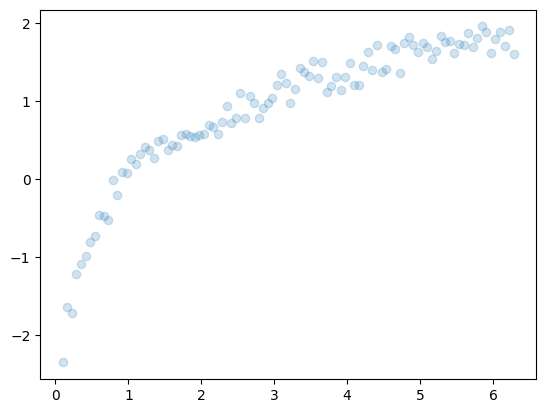

In [28]:
N_SAMPLES = 100
x = np.linspace(0.1, 2*np.pi, N_SAMPLES)[:, None]
# y = np.sin(x) + (rng.random((N_SAMPLES, 1)) - 0.5) / 2
y = np.log(x) + (rng.random((N_SAMPLES, 1)) - 0.5) / 2
plt.scatter(x, y, alpha=0.2)

In [29]:
training_idx = int(N_SAMPLES / 2)  # int(N_SAMPLES*0.75)
train_idxs = list(range(0, training_idx))
test_idxs = list(range(training_idx, N_SAMPLES))
x_train = x[train_idxs]
x_test = x[test_idxs]
y_train = y[train_idxs]
y_test = y[test_idxs]

In [30]:
mlp = MLPRegressor((150, 150, 150), max_iter=1000, random_state=SEED)
mlp.fit(x_train, y_train.ravel())
test_predict = mlp.predict(x_test)
train_predict = mlp.predict(x_train)

Training RMSE: 0.12
Testing RMSE: 0.31


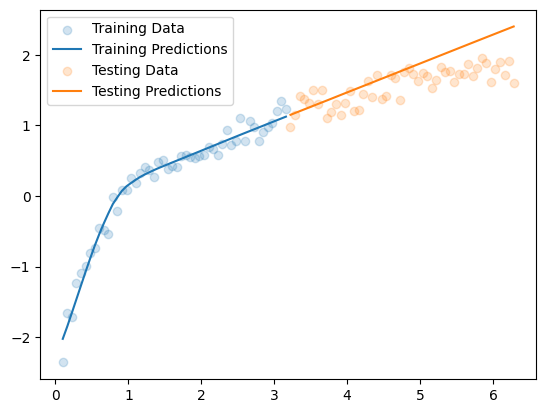

In [31]:
plt.scatter(x_train, y_train, label="Training Data", alpha=0.2)
plt.plot(x_train, train_predict, label="Training Predictions")
plt.scatter(x_test, y_test, label="Testing Data", alpha=0.2)
plt.plot(x_test, test_predict, label="Testing Predictions")
plt.legend()
train_error = root_mean_squared_error(y_train, train_predict)
test_error = root_mean_squared_error(y_test, test_predict)
print(f"Training RMSE: {train_error:.2f}\nTesting RMSE: {test_error:.2f}")

Training RMSE: 0.10
Testing RMSE: 0.72


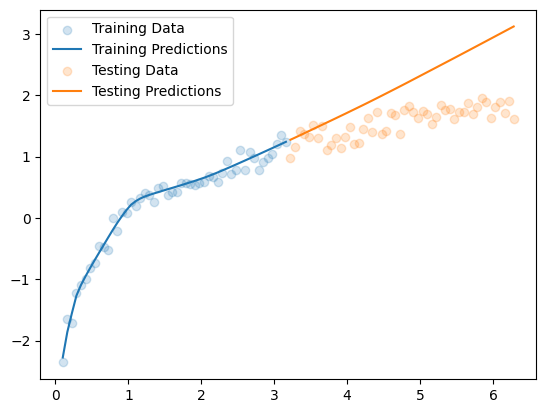

In [32]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

pairwise_x_train = np.empty((training_idx**2, 2))
pairwise_y_train = np.empty((training_idx**2, 1))
count = 0
for i in range(training_idx):
    for j in range(training_idx):
        pairwise_x_train[count, 0] = x_train[i, 0]
        pairwise_x_train[count, 1] = x_train[j, 0]
        pairwise_y_train[count, 0] = y_train[i, 0] - y_train[j, 0]
        count += 1

diff_mlp = MLPRegressor((150, 150, 150), max_iter=1000, random_state=SEED)
diff_mlp.fit(pairwise_x_train, pairwise_y_train.ravel())

# map the predictions back to the real space by using some number of 'anchors'
# and averaging the predictions
n_anchors = 10
anchor_idxs = rng.choice(np.arange(y_train.shape[0]), n_anchors)
x_anchors = np.tile(x_train[anchor_idxs], (x_test.shape[0], 1))
y_anchors = np.tile(y_train[anchor_idxs], (x_test.shape[0], 1))
pairwise_x_test = np.concatenate((x_anchors, np.repeat(x_test, n_anchors, 0)), axis=1)
pairwise_test_pred = diff_mlp.predict(pairwise_x_test)
pairwise_test_pred = y_anchors - pairwise_test_pred[:, None]
# do the same for training
x_anchors = np.tile(x_train[anchor_idxs], (x_train.shape[0], 1))
y_anchors = np.tile(y_train[anchor_idxs], (x_train.shape[0], 1))
pairwise_x_train = np.concatenate((x_anchors, np.repeat(x_train, n_anchors, 0)), axis=1)
pairwise_train_pred = diff_mlp.predict(pairwise_x_train)
pairwise_train_pred = y_anchors - pairwise_train_pred[:, None]

test_predict = np.array(list(map(np.mean, np.split(pairwise_test_pred, y_test.shape[0]))))
train_predict = np.array(list(map(np.mean, np.split(pairwise_train_pred, y_train.shape[0]))))

y_train = scaler.inverse_transform(y_train)
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test)
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))

plt.scatter(x_train, y_train, label="Training Data", alpha=0.2)
plt.plot(x_train, train_predict, label="Training Predictions")
plt.scatter(x_test, y_test, label="Testing Data", alpha=0.2)
plt.plot(x_test, test_predict, label="Testing Predictions")
plt.legend()
train_error = root_mean_squared_error(y_train, train_predict)
test_error = root_mean_squared_error(y_test, test_predict)
print(f"Training RMSE: {train_error:.2f}\nTesting RMSE: {test_error:.2f}")